# Recharge and Particles - Self Check Example

## Model Description 
This is a steady state box model with recharge

#### Dimensions: 
- 25 by 25 by 1
- dx = dy = 100 m
- dz = 10 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is no flow (i.e. a closed basin) 
 - Left boundary is a constant head of 7 m relative to the datum, which is located at the bottom of the domain. 
 - Recharge occurs at a rate of 5E-6 m/d uniformly across the domain
 
### Wells
 - one well located in row=12, col=12 pumping at a rage of -10 m3/day

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

## 2. Create the model object

In [2]:
modelname = "recharge_tutorial"
model_ws = "./recharge"
moddir="../../../modflow/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name=moddir, model_ws=model_ws)
iu_cbc = 130
#moddir = os.getcwd()+"\\modflowdir\\mf2005.exe"

In [3]:
#optional delete old run files
run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel', '.nam']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the Packages


### Discretization (DIS package)

For more details on DIS package inputs refer to : http://modflowpy.github.io/flopydoc/mfdis.html

In [4]:
nrow = 25 #number of rows
ncol = 25 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x diretion 
dy= 100 #width of grid cells in y diretion 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 10.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)
print(dis)


    MODFLOW Discretization Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.Modflow`) to which
        this package will be added.
    nlay : int
        Number of model layers (the default is 1).
    nrow : int
        Number of model rows (the default is 2).
    ncol : int
        Number of model columns (the default is 2).
    nper : int
        Number of model stress periods (the default is 1).
    delr : float or array of floats (ncol), optional
        An array of spacings along a row (the default is 1.0).
    delc : float or array of floats (nrow), optional
        An array of spacings along a column (the default is 0.0).
    laycbd : int or array of ints (nlay), optional
        An array of flags indicating whether or not a layer has a Quasi-3D
        confining bed below it. 0 indicates no confining bed, and not zero
        indicates a confining bed. LAYCBD for the bottom layer must be 0. (the
    

### Constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: http://modflowpy.github.io/flopydoc/mfbas.html

In [5]:
#Define cell activity (IBOUND)
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
#set constand head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#Define Starting Heads
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 7    #replace first (left) col with desired head value

#print("starting head values: \n", H_init)

#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### Plot the grid and ibound

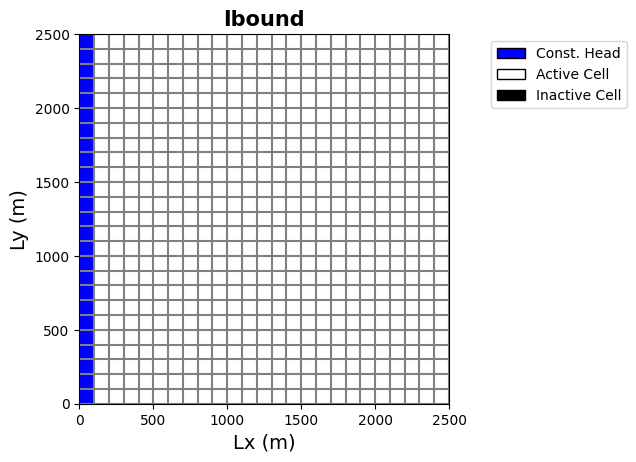

In [6]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

### Layer Properties  (LPF Package)

For more details on LPF package see: http://modflowpy.github.io/flopydoc/mflpf.html

In [7]:
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

#assigns horiz  and vertical Ks and saves cell-by-cell budget data
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

### Outputs by stress period (OC Package)
For more details on OC Package: http://modflowpy.github.io/flopydoc/mfoc.html

In [8]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


### Numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html


In [9]:
pcg = flopy.modflow.ModflowPcg(model=m)

### Recharge (RCH Package)
For more details on the RCH package see: http://modflowpy.github.io/flopydoc/mfrch.html and https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?rch.htm

In [10]:
#uniform recharge everywhere 
rech_uniform = 5e-6                             #define uniform recharge flux (m/day)
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+5e-6
#print(rech_zone)
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

#Recharge on 1/3 of the domain 
#rech_zone = np.zeros((nrow,ncol))                            #define an array of zeros of dim (nrow,ncol)
#rech_zone[:,20:25] = 2.4e-5                                    #set recharge in rightmost 5 columns
#print(rech_zone)
#rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone)     #create rch object

### Well Package (WEL)

In [11]:
pumping_rate = -10 #in m^3/d, negative for pumping/positive for injection
well_loc=(0,12,12)
well_1 = [i for i in well_loc] + [-10]
print("Well 1 [layer, row, column, flux]: \n", well_1)

wel_spd = {0: [well_1]}
print("Well Stress Period Data: \n", wel_spd)

#Create flopy wel object 
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd, ipakcb=53)

Well 1 [layer, row, column, flux]: 
 [0, 12, 12, -10]
Well Stress Period Data: 
 {0: [[0, 12, 12, -10]]}


## 4. Write inputs  

In [12]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


## 5. Run the model

In [13]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: recharge_tutorial.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/11/04 19:55:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/11/04 19:55:48
 Elapsed run time:  0.025 Seconds

  Normal termination of simulation


## 6. Add particles

We will be using MODPATH 7 for this documentation for modpath can be found here:

 - MODPATH website - https://www.usgs.gov/software/modpath-a-particle-tracking-model-modflow
 - MODPATH manual - https://pubs.usgs.gov/of/2016/1086/ofr20161086.pdf
 - Flopy Documenation - https://modflowpy.github.io/flopydoc/code.html#modpath-packages

Some example FloPy Notebooks: 
 - https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_modpath7_structured_example.ipynb
 - https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_modpath7_create_simulation.ipynb

### Setup and Run the particle model 

In [16]:
moddirmp="../../../modflow/mp7"

# create basic forward tracking modpath simulation
mpname=os.path.join(modelname + '_mp')
print(mpname)


# Select a set of nodes to add particles too

#first make a list of the cells you want to add where cells are specified by ther (layer, row, column)
plocs = []
for idx in range(nrow):
    plocs.append((0, idx, 10))
print(plocs)

#then convert these locations to their node numbers
nodesr = m.dis.get_node(plocs)
print(nodesr)


#setup the modpath model starting particles just in the cells you listed and doing backward tracking
#mp = flopy.modpath.Modpath7.create_mp7(modelname=mpname, trackdir='backward', flowmodel=m,  
#                                       rowcelldivisions=2, columncelldivisions=1, layercelldivisions=1,
 #                                       exe_name=moddirmp, nodes=nodesr)

#setup the modpath model starting particles everywhere and doing forward tracking
mp = flopy.modpath.Modpath7.create_mp7(modelname=mpname, trackdir='forward', flowmodel=m,  model_ws=model_ws,
                                       rowcelldivisions=1, columncelldivisions=1, layercelldivisions=1,
                                        exe_name=moddirmp)


# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

recharge_tutorial_mp
[(0, 0, 10), (0, 1, 10), (0, 2, 10), (0, 3, 10), (0, 4, 10), (0, 5, 10), (0, 6, 10), (0, 7, 10), (0, 8, 10), (0, 9, 10), (0, 10, 10), (0, 11, 10), (0, 12, 10), (0, 13, 10), (0, 14, 10), (0, 15, 10), (0, 16, 10), (0, 17, 10), (0, 18, 10), (0, 19, 10), (0, 20, 10), (0, 21, 10), (0, 22, 10), (0, 23, 10), (0, 24, 10)]
[10, 35, 60, 85, 110, 135, 160, 185, 210, 235, 260, 285, 310, 335, 360, 385, 410, 435, 460, 485, 510, 535, 560, 585, 610]
FloPy is using the following executable to run the model: ../../../../modflow/mp7

MODPATH Version 7.2.001   
Program compiled May 24 2025 11:45:03 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles termina

(True, [])

## 6. Plotting and analysis

### Read in particle files

In [22]:
#load in the flow path file
fpth = os.path.join(f'{model_ws}/{mpname}.mppth')
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(f'{model_ws}/{mpname}.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  
eall = e.get_alldata()

#make a subset which is the partlces that end in the well 
nodewell = m.dis.get_node([well_loc])
print(well_loc)
print(nodewell)
pwell = p.get_destination_pathline_data(dest_cells=nodewell)
ewell= e.get_destination_endpoint_data(dest_cells=nodewell)

(0, 12, 12)
[312]


### Plot particle pathlines

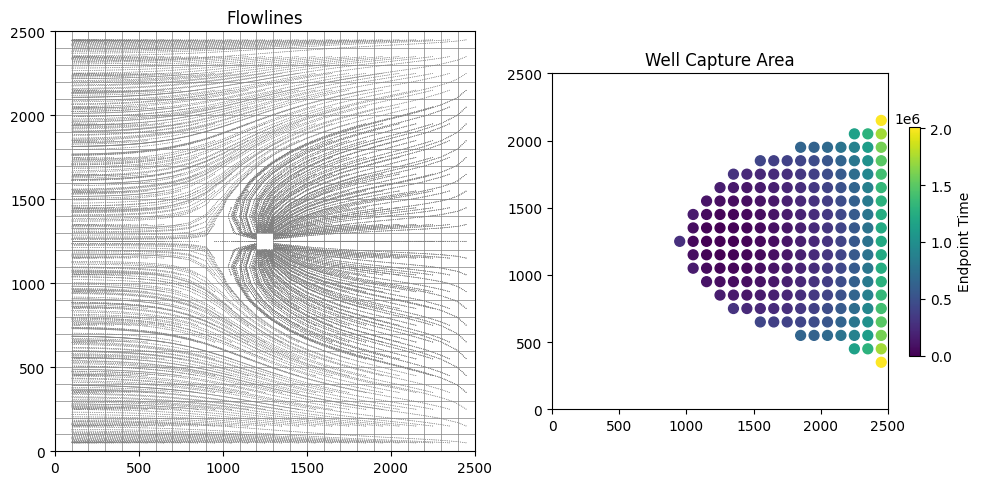

In [23]:
f, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

ax = axes[0]
ax.set_aspect('equal')
ax.set_title('Flowlines')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pwell, layer='all', color='green', lw=0.5, linestyle=':', label='captured by well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
#mm.plot_endpoint(eall, direction='ending', colorbar=True, shrink=0.5);
#mm.plot_endpoint(eall, direction='starting')
#mm.ax.legend();

ax = axes[1]
ax.set_aspect('equal')
ax.set_title('Well Capture Area')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_endpoint(ewell, direction='starting', colorbar=True, shrink=0.5);
#mm.plot_grid(lw=0.5)
#mm.plot_pathline(prb, layer='all', color='green', lw=0.5, linestyle=':', label='captured by rivers')

plt.tight_layout();

### Read in MODFLOW outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

In [24]:
#heads
headobj = bf.HeadFile(f'{model_ws}/{modelname}.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#Water balance
budgobj = bf.CellBudgetFile(f'{model_ws}/{modelname}.cbc')   #reads the cell budget file    
budgobj.list_records()
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     
         #string options are in the list file under output control (make sure to include spaces!)
#print("Flow through Right Face of Grid Cells m^3/d \n", frf,
#     "\n Flow through Front Face of Grid Cells m^3/d \n", fff)

#print('timesteps:', times)         
#print('final head:', 'dimensions', np.shape(head), '\n', head)    
#print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
#print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)

(1, 1, b'   CONSTANT HEAD', 25, 25, -1, 2, 1.0, 1.0, 1.0, b'', b'', b'', b'')
(1, 1, b'FLOW RIGHT FACE ', 25, 25, -1, 1, 1.0, 1.0, 1.0, b'', b'', b'', b'')
(1, 1, b'FLOW FRONT FACE ', 25, 25, -1, 1, 1.0, 1.0, 1.0, b'', b'', b'', b'')
(1, 1, b'           WELLS', 25, 25, -1, 5, 1.0, 1.0, 1.0, b'', b'', b'', b'')
(1, 1, b'        RECHARGE', 25, 25, -1, 3, 1.0, 1.0, 1.0, b'', b'', b'', b'')


/workspaces/hwrs564a_course_materials_arbennett/.venv/lib/python3.11/site-packages/flopy/utils/binaryfile/__init__.py:1311: DeprecationWarning: list_records() is deprecated; use headers instead.
  warnings.warn(


### Plot head transect

Head Gradient -0.0005336895 m/m


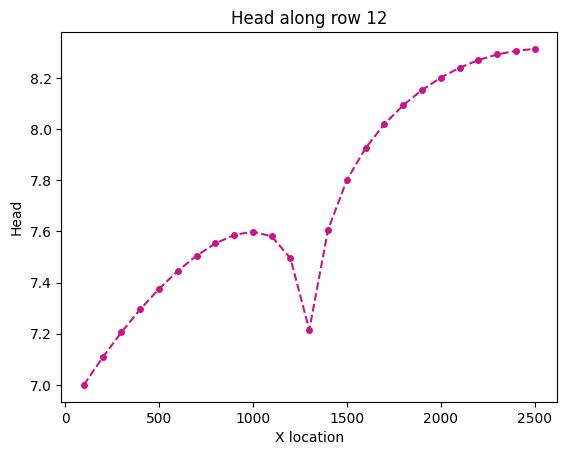

In [ ]:
fig4 = plt.figure() 
x=np.arange(100,2600,100) 
y=head[0,5,:]
plt.plot(x,head[0,12,:],marker='o', color='mediumvioletred', markersize=4, linestyle='--')
plt.title('Scatter plot pythonspot.com')
plt.xlabel('X location')
plt.ylabel('Head')
plt.title("Head along row 12")

hgrad=(head[0,5,0]-head[0,5,-1])/Lx
print("Head Gradient", hgrad, "m/m") 


### 3D head surface

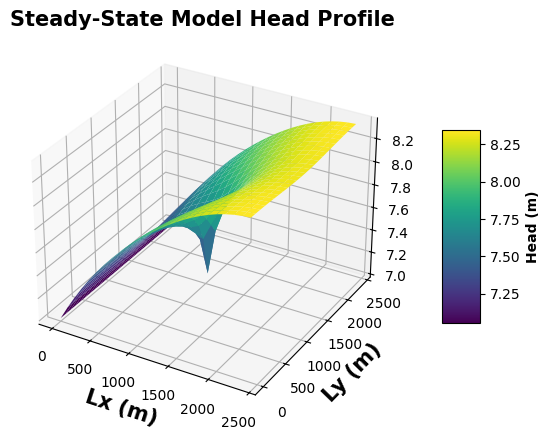

In [ ]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d, ax = plt.subplots(1, 1, figsize=(12,5), subplot_kw={'projection': '3d'})

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')

###  Head Contours

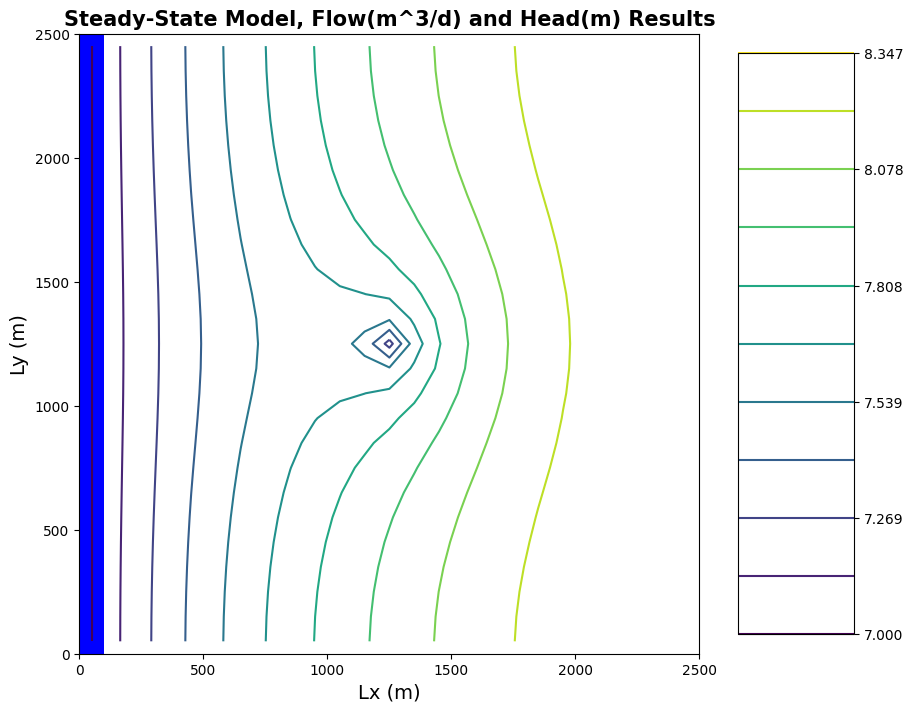

In [ ]:
#plot results
fig3=plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)